<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-driven-science-and-engineering/01-svd/09_pca_truncation_and_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA:Truncation and Alignment

Deciding how many singular values to keep, i.e., where to truncate, is one of the most
important and contentious decisions when using the SVD. There are many factors, including
specifications on the desired rank of the system, the magnitude of noise, and the
distribution of the singular values.

Often, one truncates the SVD at a rank `r` that captures a
predetermined amount of the variance or energy in the original data, such as `90%` or `99%` truncation.

Other techniques involve
identifying “elbows” or “knees” in the singular value distribution, which may denote the
transition from singular values that represent important patterns from those that represent
noise.

Truncation may be viewed as a hard threshold on singular values, where values
larger than a threshold $\tau$ are kept, while remaining singular values are truncated.

In addition, the alignment of data significantly impacts the rank of the SVD approximation.

The SVD essentially relies on a separation of variables between the columns and rows
of a data matrix.

##Setup

In [9]:
import numpy as np
import scipy.io
import os

import skimage.transform

import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

##Noisy low-rank data

Let's artificially construct a rank-two
matrix and contaminate the data with Gaussian white noise. 

A de-noised and dimensionally
reduced matrix is then obtained using the threshold, as well as a truncation
keeping `90%` of the cumulative sum of singular values.

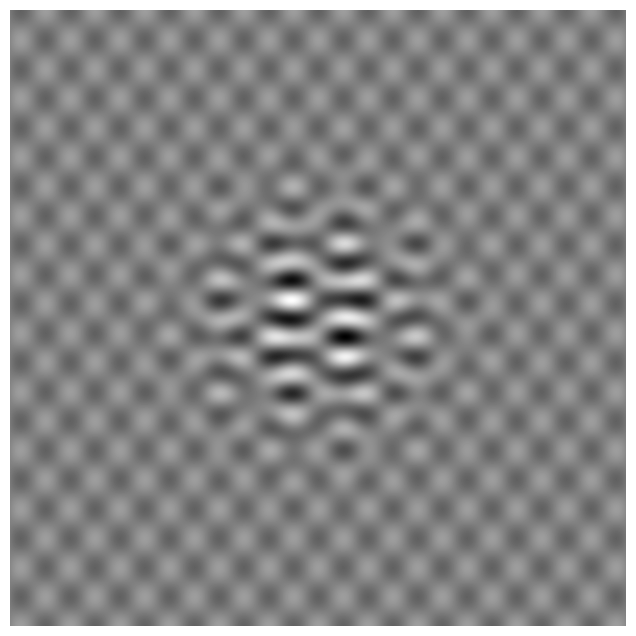

In [2]:
# Generate underlying low-rank data
t = np.arange(-3, 3, 0.01)

# Compute eigenfaces on mean-subtracted training data
U_true = np.array([np.cos(17 * t) * np.exp(-t ** 2), np.sin(11 * t)]).T
S_true = np.array([[2, 0], [0, 0.5]])
V_true = np.array([np.sin(5 * t) * np.exp(-t ** 2), np.cos(13 * t)]).T

X = U_true @ S_true @ V_true.T

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

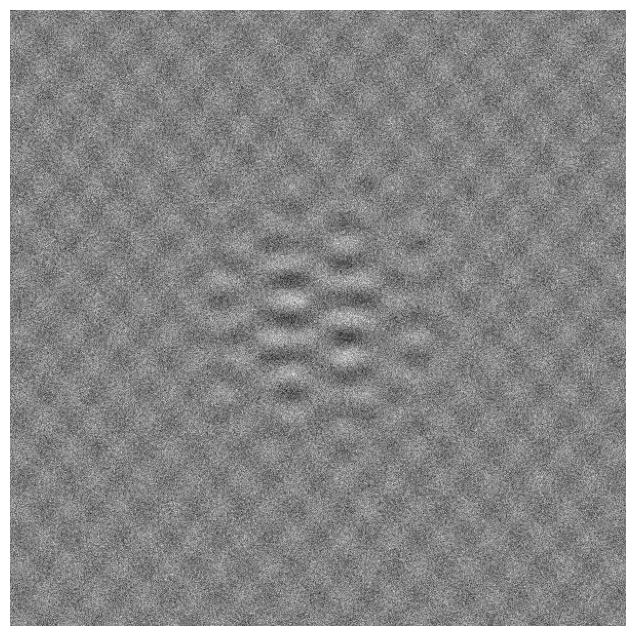

In [3]:
# Contaminate signal with noise
sigma = 1
X_noisy = X + sigma * np.random.randn(*X.shape)

plt.imshow(X_noisy)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

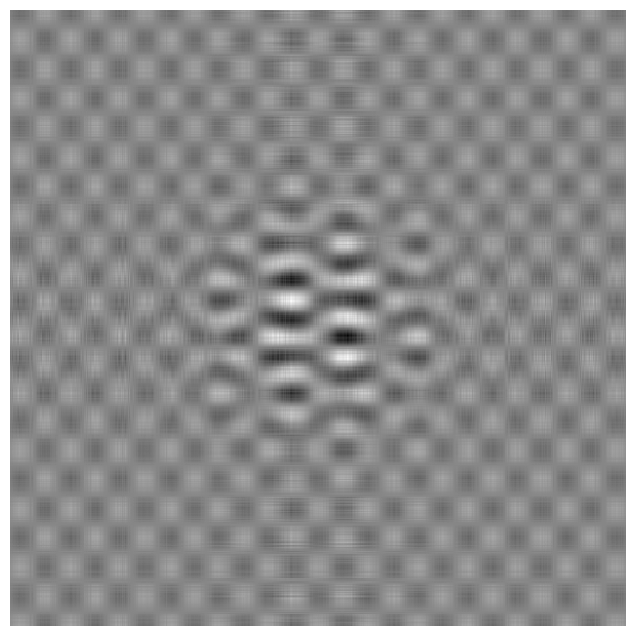

In [4]:
# Truncate using optimal hard threshold
U, S, VT = np.linalg.svd(X_noisy, full_matrices=0)

N = X_noisy.shape[0]
cuttoff = (4 / np.sqrt(3)) * np.sqrt(N) * sigma  # Hard threshold
r = np.max(np.where(S > cuttoff))                # Keep modes w/ S > cutoff

X_clean = U[:, : (r + 1)] @ np.diag(S[:(r + 1)]) @ VT[:(r + 1), :]

plt.imshow(X_clean)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

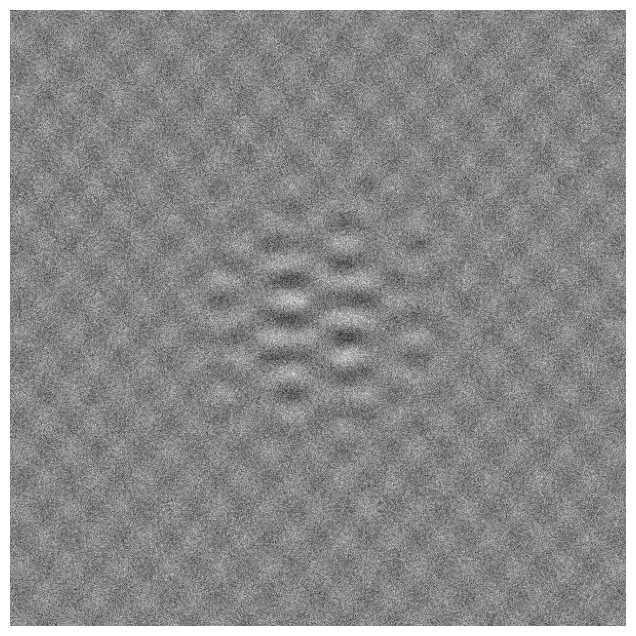

In [5]:
# Truncate to keep 90% of cumulative sum
cds = np.cumsum(S) / np.sum(S)     # Cumulative energy
r90 = np.min(np.where(cds > 0.90)) # Find r to keep 90% sum

X90 = U[:, : (r90 + 1)] @ np.diag(S[:(r90 + 1)]) @ VT[:(r90 + 1), :]

plt.imshow(X90)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

It is clear that the hard threshold is
able to filter the noise more effectively.

Let's plot Singular Values.

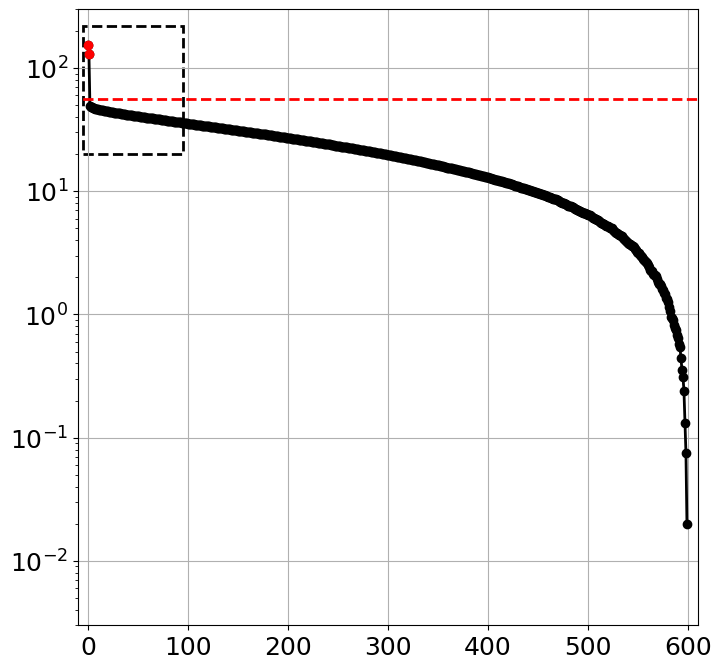

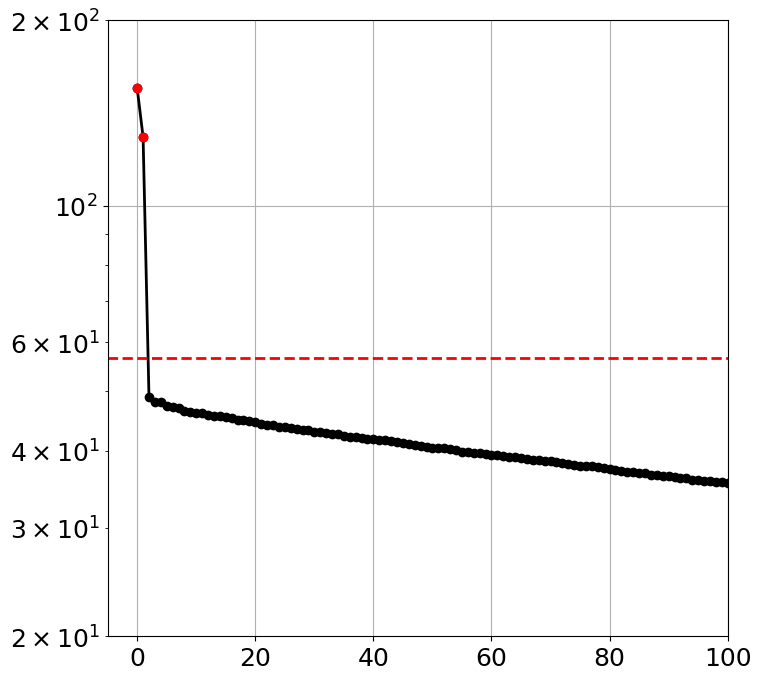

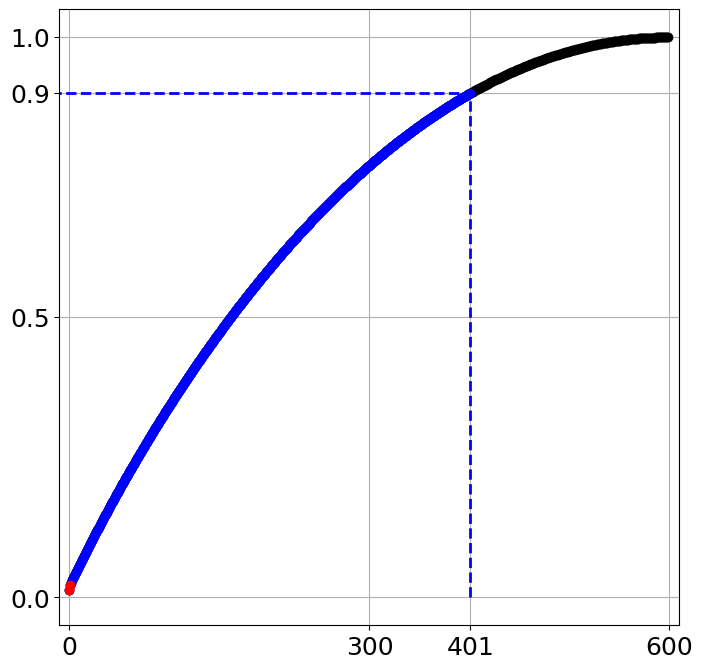

In [6]:
fig1,ax1 = plt.subplots(1)

ax1.semilogy(S,'-o', color='k', linewidth=2)
ax1.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax1.plot(np.array([-20, N+20]),np.array([cuttoff, cuttoff]),'--', color='r', linewidth=2)
rect = patches.Rectangle((-5,20),100,200,linewidth=2,linestyle='--',facecolor='none',edgecolor='k')
ax1.add_patch(rect)
plt.xlim((-10,610))
plt.ylim((0.003,300))
ax1.grid()
plt.show()

fig2,ax2 = plt.subplots(1)

ax2.semilogy(S,'-o', color='k', linewidth=2)
ax2.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax2.plot(np.array([-20, N+20]),np.array([cuttoff, cuttoff]),'--', color='r', linewidth=2)
plt.xlim((-5,100))
plt.ylim((20,200))
ax2.grid()
plt.show()

fig3,ax3 = plt.subplots(1)
ax3.plot(cds,'-o',color='k',linewidth=2)
ax3.plot(cds[:(r90+1)],'o',color='b',linewidth=2)
ax3.plot(cds[:(r+1)],'o',color='r',linewidth=2)
plt.xticks(np.array([0, 300, r90, 600]))
plt.yticks(np.array([0, 0.5, 0.9, 1]))
plt.xlim((-10,610))
ax3.plot(np.array([r90, r90, -10]),np.array([0, 0.9, 0.9]),'--',color='b',linewidth=2)

ax3.grid()
plt.show()

##Importance of Data Alignment

Here, we discuss common pitfalls of the SVD associated with misaligned data that is one of the central weaknesses of the SVD for
dimensionality reduction and coherent feature extraction in data.

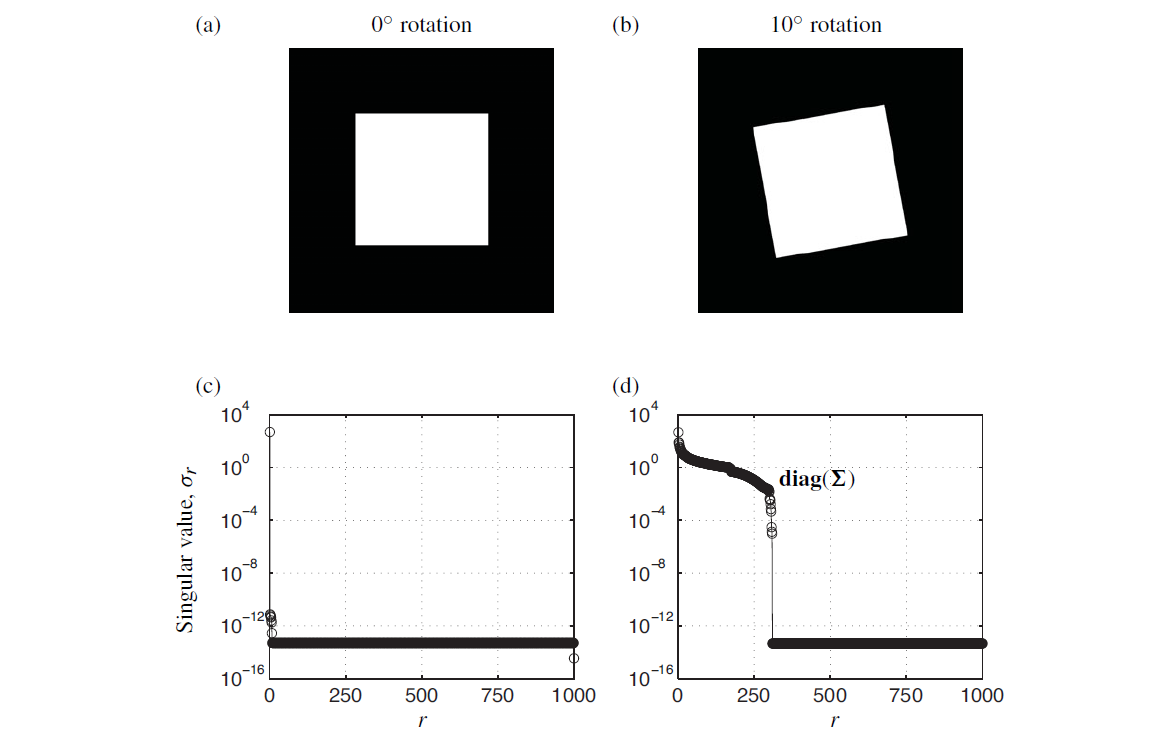

The reason that this example breaks down is that the SVD is fundamentally geometric,
meaning that it depends on the coordinate system in which the data is represented.

As
we have seen earlier, the SVD is only generically invariant to unitary transformations,
meaning that the transformation preserves the inner product. This fact may be viewed
as both a strength and a weakness of the method. 

First, the dependence of SVD on the
inner product is essential for the various useful geometric interpretations. Moreover, the
SVD has meaningful units and dimensions. 

However, this makes the SVD sensitive to
the alignment of the data. In fact, the SVD rank explodes when objects in the columns
translate, rotate, or scale, which severely limits its use for data that has not been heavily
pre-processed.

The inability of the SVD to capture translations and rotations of the data is a major limitation.

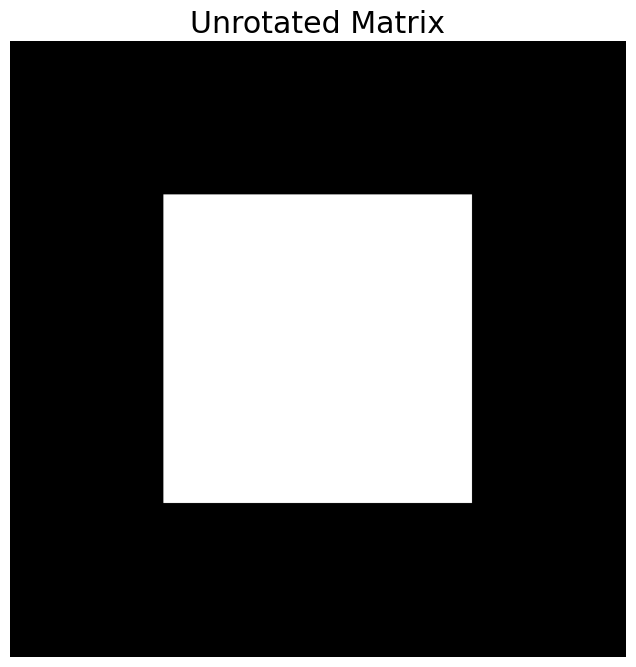

In [7]:
# Unrotated Matrix
n = 1000
q = int(n / 4)

X = np.zeros((n, n))
X[(q - 1): (3 * q), (q - 1): (3 * q)] = 1

plt.imshow(X)
plt.set_cmap('gray')
plt.title('Unrotated Matrix')
plt.axis('off')
plt.show()

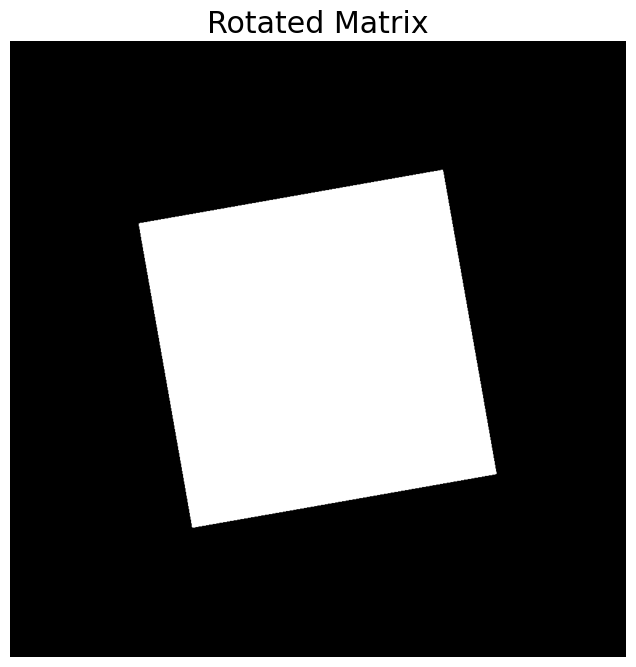

In [12]:
# Rotated Matrix
X_rotated = skimage.transform.rotate(X, 10)
X_rotated[np.nonzero(X_rotated)] = 1

plt.imshow(X_rotated)
plt.set_cmap('gray')
plt.title('Rotated Matrix')
plt.axis('off')
plt.show()

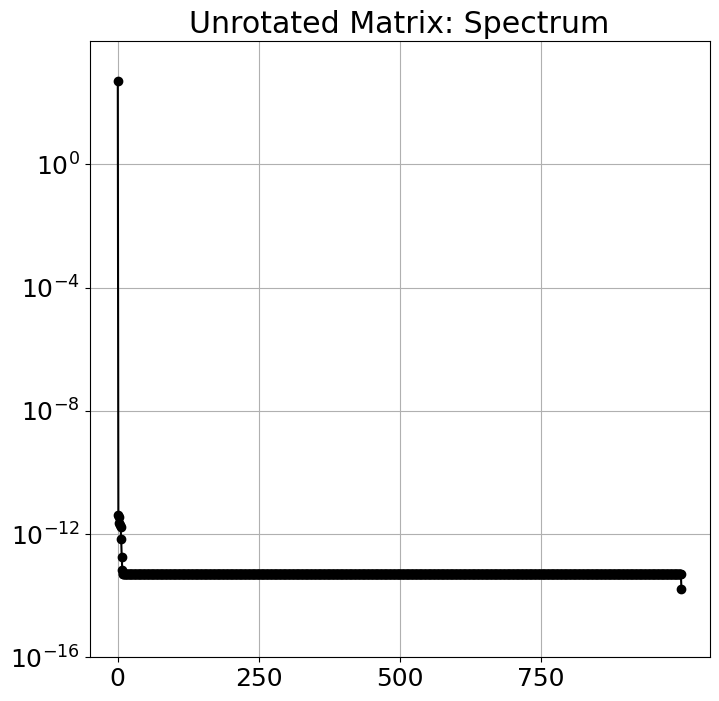

In [14]:
# Unrotated Matrix: Spectrum
U, S, VT = np.linalg.svd(X, full_matrices=0)

plt.semilogy(S, "-o", color="k")
plt.ylim((10 ** (-16), 10 ** (4) + 1))
plt.yticks(np.power(10, np.arange(-16, 4, 4, dtype=float)))
plt.xticks(np.arange(0, 1000, 250))
plt.grid()
plt.title('Unrotated Matrix: Spectrum')
plt.show()

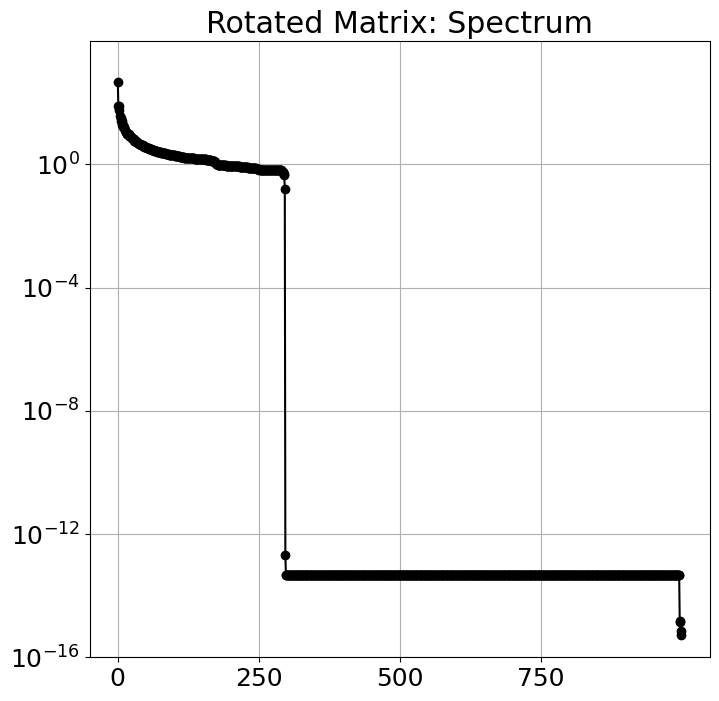

In [15]:
# Rotated Matrix: Spectrum
U, S, VT = np.linalg.svd(X_rotated, full_matrices=0)

plt.semilogy(S, "-o", color="k")
plt.ylim((10 ** (-16), 10 ** (4) + 1))
plt.yticks(np.power(10, np.arange(-16, 4, 4, dtype=float)))
plt.xticks(np.arange(0, 1000, 250))
plt.grid()
plt.title('Rotated Matrix: Spectrum')
plt.show()

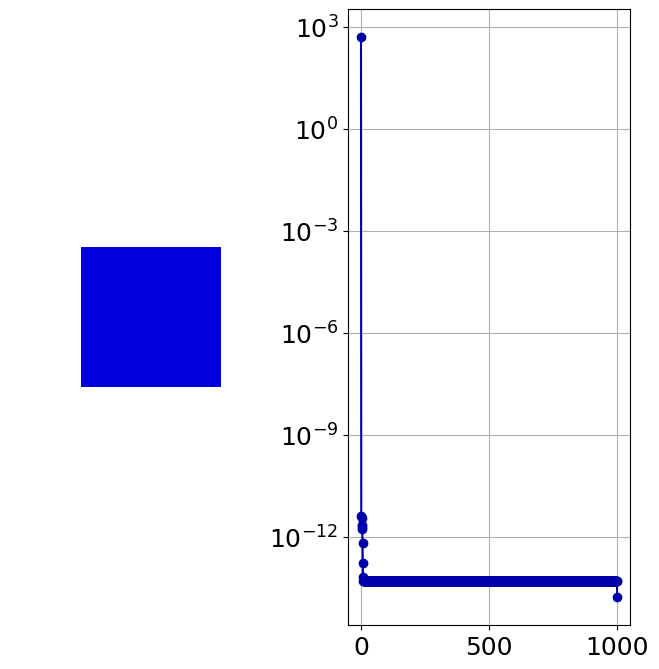

In [17]:
# Sweep through 12 different angles, from 0:4:44 degrees
n_angles = 12
cm_np = np.array([[0,0,2/3],
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

cmap = plt.cm.jet
cmap.set_bad(alpha = 0.0)

U, S, VT = np.linalg.svd(X,full_matrices=0)

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
plt.imshow(np.ma.masked_where(X == 0, X),vmin=0,vmax=n_angles)
plt.set_cmap(cmap)
plt.axis('off')


ax2 = fig1.add_subplot(122)
plt.semilogy(S,'-o',color=tuple(cm_np[0]))
plt.grid()

plt.show()

<ipython-input-18-917f0a36dfcc>:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[1].axis("on")


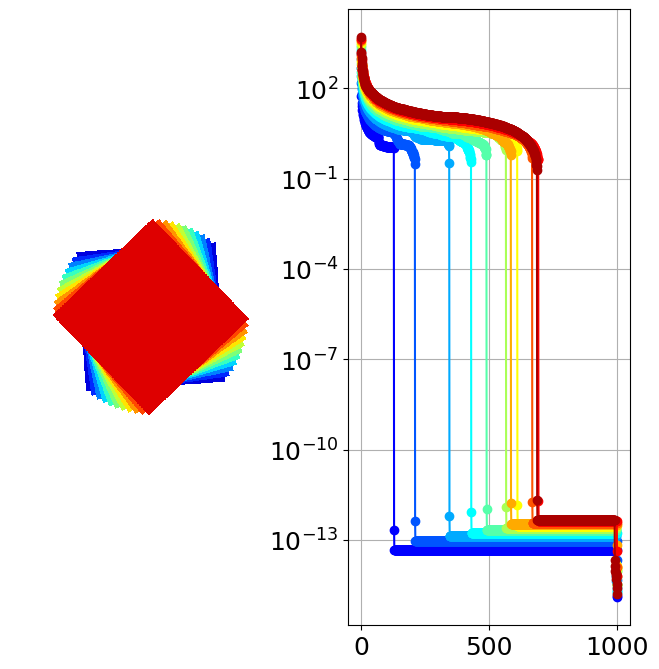

In [18]:
# Sweep through 12 different angles, from 0:4:44 degrees
X_rotated = X

fig, axs = plt.subplots(1,2)
for j in range(n_angles):
  X_rotated = skimage.transform.rotate(X, j * 4)  # rotate by theta = j*4 degrees
  X_rotated[np.nonzero(X_rotated)] = j

  U, S, VT = np.linalg.svd(X_rotated)

  axs[0].imshow(np.ma.masked_where(X_rotated == 0, X_rotated), vmin=0, vmax=n_angles)
  plt.set_cmap(cmap)
  axs[0].axis('off')


  ax2 = fig1.add_subplot(122)
  axs[1].semilogy(S,'-o', color=tuple(cm_np[j]))
  axs[1].axis("on")
  axs[1].grid(1)

plt.show()